In [1]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
#tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPool2D, Dense, Dropout, Flatten, Conv2D, InputLayer, Activation, Add, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping 

In [2]:
# Creating dataframe by iterating through filepaths
tumor_dir=r'Dataset/BrainTumor'
healthy_dir=r'Dataset/Healthy'
filepaths = []
labels= []
dict_list = [tumor_dir, healthy_dir]
for i, j in enumerate(dict_list):
    flist=os.listdir(j)
    for f in flist:
        fpath=os.path.join(j,f)
        filepaths.append(fpath)
        if i==0:
          labels.append('cancer')
        else:
          labels.append('healthy') 
    
Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
tumor_data = pd.concat([Fseries,Lseries], axis=1)
tumor_df = pd.DataFrame(tumor_data)
print(tumor_df.head())
print(tumor_df["labels"].value_counts())

                            filepaths  labels
0   Dataset/BrainTumor\Cancer (1).jpg  cancer
1   Dataset/BrainTumor\Cancer (1).png  cancer
2   Dataset/BrainTumor\Cancer (1).tif  cancer
3  Dataset/BrainTumor\Cancer (10).jpg  cancer
4  Dataset/BrainTumor\Cancer (10).tif  cancer
cancer     2513
healthy    2087
Name: labels, dtype: int64


In [3]:
#shape of datatset
tumor_df.shape

(4600, 2)

In [4]:
#splitting data
train_images, test_images = train_test_split(tumor_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(tumor_df, test_size=0.2, random_state=42)

In [5]:

#shape of splitted data
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(3680, 2)
(1380, 2)
(920, 2)
(3220, 2)


In [6]:
#Generate batches of tensor image data with real-time data augmentation.
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=256,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=256,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=8,
                                    shuffle=False
                                   )


Found 3680 validated image filenames belonging to 2 classes.
Found 1380 validated image filenames belonging to 2 classes.
Found 920 validated image filenames belonging to 2 classes.


In [7]:
classes=list(train.class_indices.keys())
print (classes)

['cancer', 'healthy']


In [8]:
def show_brain_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator 
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

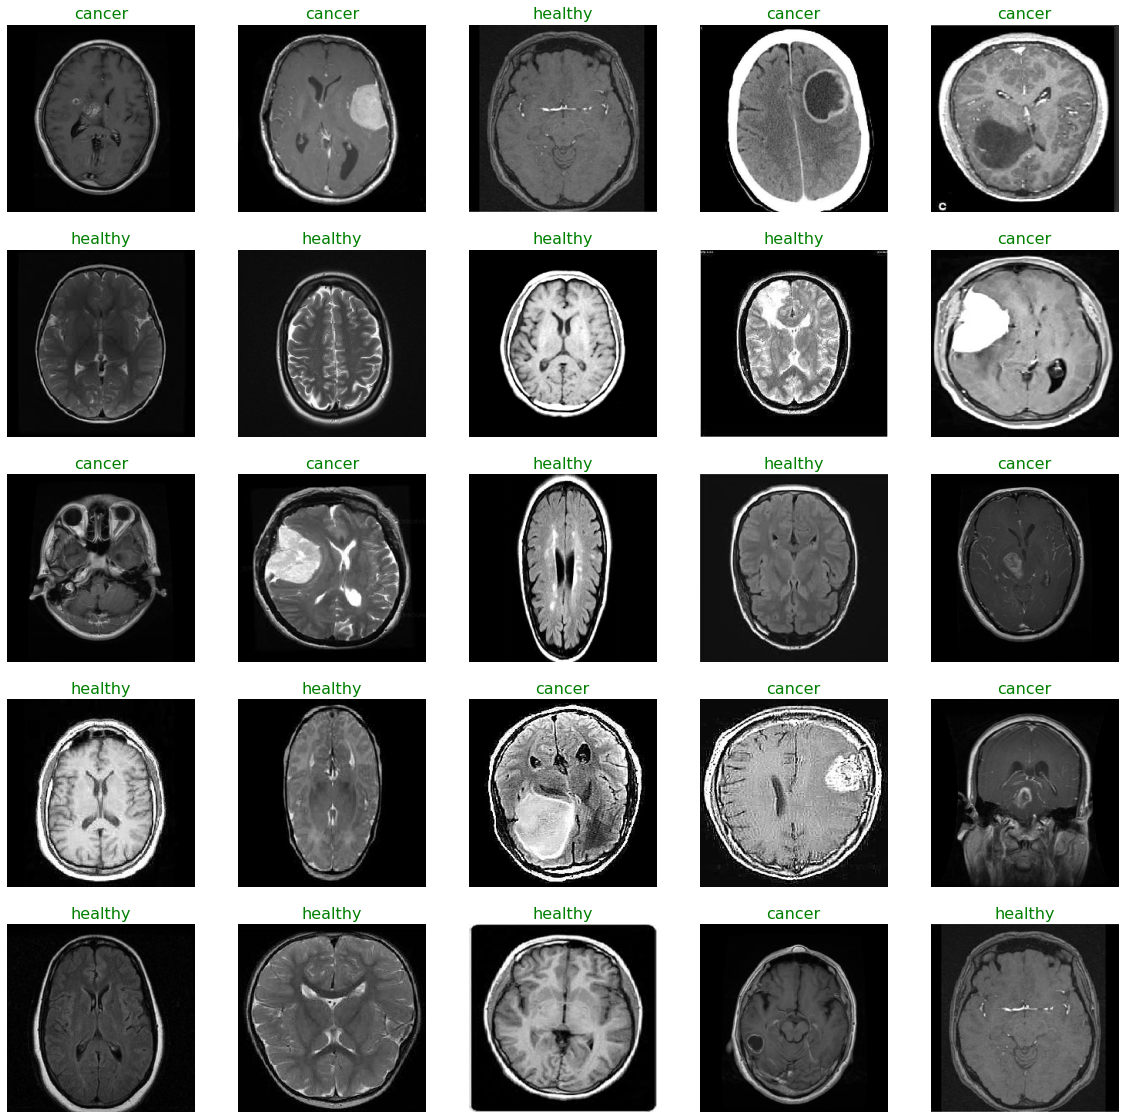

In [9]:
show_brain_images(train)

In [10]:
model = keras.Sequential()
model.add(InputLayer(input_shape=(244,244,3)))
model.add(Conv2D(filters=32,kernel_size=3, activation="relu", padding="same"))
model.add(MaxPool2D())
model.add(Conv2D(filters=64,kernel_size=3, activation="relu", padding="same"))
model.add(MaxPool2D())


model.add(Flatten())


model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Dense(64, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Dense(2, activation="sigmoid"))


model.compile(optimizer=Adam(0.001), loss = SparseCategoricalCrossentropy(), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 244, 244, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 122, 122, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 238144)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               30482560  
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               5

In [11]:
earlystopping = EarlyStopping(monitor="val_loss", mode="min", patience=5, restore_best_weights = True)

In [12]:
#fitting model
History = model.fit(train, validation_data= val, epochs=10, verbose=1, callbacks=[earlystopping])

Epoch 1/10


InvalidArgumentError:  logits and labels must have the same first dimension, got logits shape [256,2] and labels shape [512]
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at C:\Users\olive\AppData\Local\Temp/ipykernel_11660/3512304638.py:2) ]] [Op:__inference_train_function_1589]

Function call stack:
train_function


Text(0.5, 1.0, 'Training and Validation Accuracy')

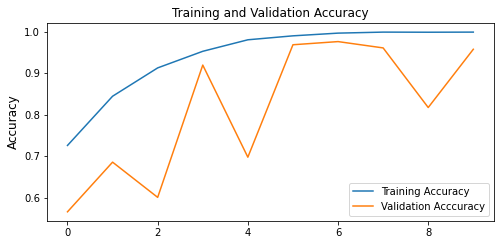

In [ ]:
acc = History.history["accuracy"] # report of model
val_acc = History.history["val_accuracy"] # history of validation data

loss = History.history["loss"]        # Training loss
val_loss = History.history["val_loss"] # validation loss

plt.figure(figsize=(8,8))
plt.subplot(2,1,1) # 2 rows and 1 columns
#plotting respective accuracy
plt.plot(acc,label="Training Accuracy")
plt.plot(val_acc, label="Validation Acccuracy")

plt.legend()
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training and Validation Accuracy", fontsize=12)

Text(0.5, 1.0, 'Training and Validation Losses')

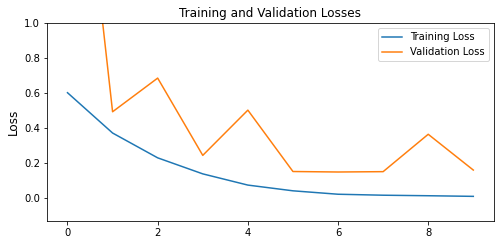

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
 
plt.plot(loss, label="Training Loss")      #Training loss
plt.plot(val_loss, label="Validation Loss") # Validation Loss

plt.legend()
plt.ylim([min(plt.ylim()),1])
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Losses", fontsize=12)

In [ ]:
model.evaluate(test, verbose=1)


44/44 [==============================] - 6s 141ms/step - loss: 0.1361 - accuracy: 0.9717


[0.13609401881694794, 0.9717391133308411]

In [ ]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:",accuracy_score(y_test, pred2)*100,"%")

              precision    recall  f1-score   support

      cancer       0.56      1.00      0.72       779
     healthy       0.00      0.00      0.00       601

    accuracy                           0.56      1380
   macro avg       0.28      0.50      0.36      1380
weighted avg       0.32      0.56      0.41      1380

Accuracy of the Model: 56.44927536231884 %


<AxesSubplot:>

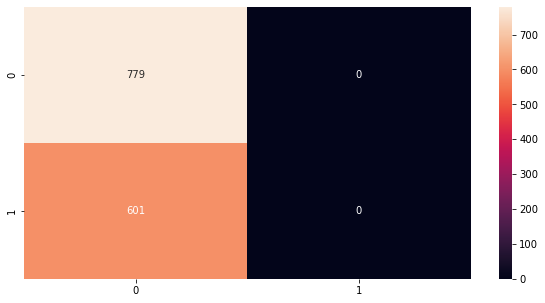

In [ ]:
# Confusion Matrix

plt.figure(figsize = (10,5))
cm = confusion_matrix(y_test, pred2)
sns.heatmap(cm, annot=True, fmt = 'g')